# 2D Model

In [1]:
import logging

logging.basicConfig(level=logging.INFO)

logger = logging.getLogger(__name__)

In [2]:
from recognizer.utils.constants import DATASET_DIR, TARGET_TO_ENCODING
from recognizer.utils.utils import get_metadata_from_filename

In [3]:
BATCH_SIZE = 128
NUM_CLASSES = 64
EPOCHS = 60

## Load Data

In [4]:
import os

import pandas as pd

targets = []
subjects = []
repetitions = []
files = []

for file in os.listdir(DATASET_DIR):
    if "left" in file:
        continue

    target, subject, repetition = get_metadata_from_filename(file)

    targets.append(target)
    subjects.append(subject)
    repetitions.append(repetition)
    files.append(str((DATASET_DIR / file).resolve()))


metadata = pd.DataFrame(
    data={
        "target": targets,
        "subject": subjects,
        "repetition": repetitions,
        "file": files,
    }
)

metadata["target_encoding"] = metadata["target"].map(TARGET_TO_ENCODING)

metadata.head()

,target,subject,repetition,file,target_encoding
0,064,002,001,/Users/facundopalavecino/Documents/DEV/ecd-tra...,63
1,035,010,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...,34
2,033,009,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...,32
3,026,002,004,/Users/facundopalavecino/Documents/DEV/ecd-tra...,25
4,023,005,002,/Users/facundopalavecino/Documents/DEV/ecd-tra...,22


### Train/Test split

In [5]:
import numpy as np

size = 1
replace = False
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]

testing_set = metadata.groupby(["target", "subject"], as_index=False).apply(fn)

testing_set.index = testing_set.index.droplevel(0)

training_set = metadata.loc[~metadata.index.isin(testing_set.index), :]

### Pre-processing functions

In [6]:
def transform(x):
    """Permutes the element to match the format expected by PyTorch: (C<channels>, H<height>, W<width>)"""
    # Transpose video from (T<frames>, Height, Width, Channels) to (Channels, Height, Width)
    return x.permute(2, 0, 1)


### Datasets

In [7]:
from recognizer.dataset.image_dataset import ImageDataset

training_dataset = ImageDataset(
    video_filenames=training_set["file"].values,
    labels=training_set["target_encoding"].values,
    transform=transform,
)

testing_dataset = ImageDataset(
    video_filenames=testing_set["file"].values,
    labels=testing_set["target_encoding"].values,
    transform=transform,
)

print(f"Training/testing set: ({len(training_dataset)}, {len(testing_dataset)})")

Training/testing set: (2560, 640)


### Data Loaders

In [8]:
import torch 

from torch import nn

from recognizer.models.simple_2d import Simple2DCNN

model = Simple2DCNN(
    num_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
)

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle = False)

test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle = False)

loss_function = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

model.to(device)


Simple2DCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=65536, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=64, bias=True)
  )
)

## Training

In [9]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from tqdm import tqdm

training_losses = []
testing_losses = []

accuracies = []
precisions = []
recalls = []
f1s = []
cm = None


for epoch in range(EPOCHS):

    logger.info(f"""
Beginning model training with parameters:
- Epochs: {EPOCHS}
- Batch Size: {BATCH_SIZE}
    """)

    logger.info(f"Epoch {epoch + 1} - Training")

    model.train()

    running_loss = 0.0

    for _, data in enumerate(train_loader):

        batch, labels = data[0].float(), data[1]
        batch = batch.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(batch)

        loss = loss_function(logits, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_training_loss = running_loss / len(train_loader)
    training_losses.append(average_training_loss)

    logger.info(f"AVG Training Loss: {average_training_loss:.2f}")

    # Evaluation
    logger.info(f"Epoch {epoch + 1} - Evaluation")

    model.eval()

    all_preds = []
    all_targets = []

    running_loss = 0.0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].float(), data[1]
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)

            _, preds = torch.max(logits, 1)

            all_preds.extend(preds.cpu())
            all_targets.extend(labels.cpu())

            loss = loss_function(logits, labels)
            running_loss += loss.item()

    average_testing_loss = running_loss / len(train_loader)
    testing_losses.append(average_testing_loss)

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    accuracies.append(accuracy_score(all_targets, all_preds))
    precisions.append(precision_score(all_targets, all_preds, average="macro"))
    recalls.append(recall_score(all_targets, all_preds, average="macro"))
    f1s.append(f1_score(all_targets, all_preds, average="macro"))

    if epoch == EPOCHS - 1:
        cm = confusion_matrix(all_targets, all_preds)

    logger.info(f"""
Epoch {epoch}:
    - Accuracy  : {accuracies[-1]}
    - Precision : {precisions[-1]}
    - Recall    : {recalls[-1]}
    - F1        : {f1s[-1]}
    """)

logger.info("Model training finised!")

INFO:__main__:
Beginning model training with parameters:
- Epochs: 60
- Batch Size: 128
    
INFO:__main__:Epoch 1 - Training
INFO:__main__:AVG Training Loss: 7.74
INFO:__main__:Epoch 1 - Evaluation
/Users/facundopalavecino/Library/Caches/pypoetry/virtualenvs/ecd-trabajo-final-UlVdN89U-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:__main__:
Epoch 0:
    - Accuracy  : 0.4671875
    - Precision : 0.5382924835124671
    - Recall    : 0.46718750000000003
    - F1        : 0.4308215712377853
    
INFO:__main__:
Beginning model training with parameters:
- Epochs: 60
- Batch Size: 128
    
INFO:__main__:Epoch 2 - Training
INFO:__main__:AVG Training Loss: 2.18
INFO:__main__:Epoch 2 - Evaluation
INFO:__main__:
Epoch 1:
    - Accuracy  : 0.646875
 

In [10]:
import subprocess

CMD = '''
on run argv
  display notification (item 2 of argv) with title (item 1 of argv) sound name "Glass"
end run
'''

def notify(title, text):
    subprocess.call(['osascript', '-e', CMD, title, text])

notify("Jupyterlab", "Entrenamiento del modelo terminado.")

## Evaluation

### Confusion Matrix

<AxesSubplot: >

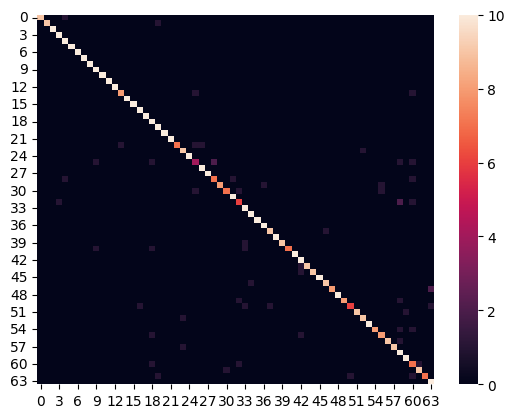

In [11]:
import seaborn as sns

sns.heatmap(data=cm)

### Accuracy/Recall/Precision

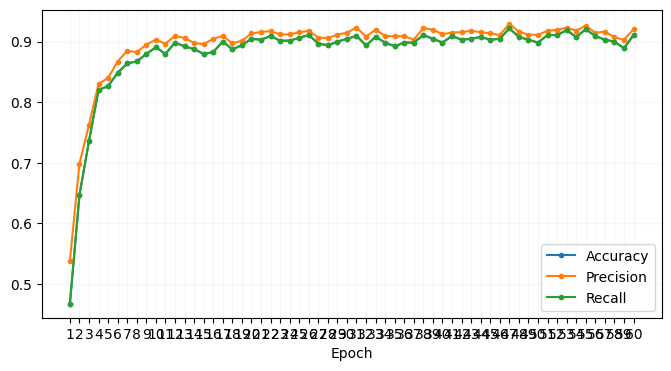

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(accuracies, label="Accuracy", marker=".")
ax.plot(precisions, label="Precision", marker=".")
ax.plot(recalls, label="Recall", marker=".")
#ax.plot(f1s, label="F1")

ax.set_xticks(range(0, epoch+1))
ax.set_xticklabels(range(1, epoch+2))
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(alpha=0.1)
plt.show()

### Loss

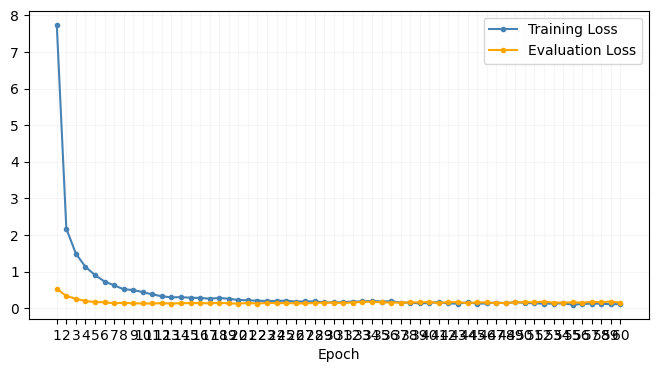

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(training_losses, label="Training Loss", marker=".", color="steelblue")
ax.plot(testing_losses, label="Evaluation Loss", marker=".", color="orange")

ax.set_xticks(range(0, epoch+1))
ax.set_xticklabels(range(1, epoch+2))
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(alpha=0.1)
plt.show()

## Save model

In [14]:
from recognizer.utils.constants import ROOT_DIR

MODELS_DIR = ROOT_DIR / "models"

MODEL_PATH = MODELS_DIR / "2d_model_1.pth"

with open(MODELS_DIR / "2d_model_1.pth", "w") as f:
        f.write("")

torch.save(model, f=MODEL_PATH)